### Classification Methods ###

This notebook assesses the following classification algorithms:

- Linear SVC ##Pending
- KNeighbors Classifier
- Random Forest

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

- Import data

In [7]:
from google.colab import files
uploaded = files.upload()

KeyboardInterrupt: ignored

In [ ]:
import io
claims = pd.read_csv(io.BytesIO(uploaded['dim_claims.csv']))
dates = pd.read_csv(io.BytesIO(uploaded['dim_date.csv']))
pa = pd.read_csv(io.BytesIO(uploaded['dim_pa.csv']))
bridge = pd.read_csv(io.BytesIO(uploaded['bridge.csv']))


- Merge data

In [ ]:
data = claims.merge(bridge, on='dim_claim_id')
data = data.merge(dates, on='dim_date_id')

- Split data

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
df = data[['drug', 'bin', 'calendar_month', 
          'calendar_day', 'day_of_week']]

X = pd.get_dummies(df, columns=['drug', 'bin'], drop_first=False)
y = data['pharmacy_claim_approved']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size=.2,
                                                   random_state=5438,
                                                   shuffle=True,
                                                   stratify=y)

In [ ]:
X.head()

,calendar_month,calendar_day,day_of_week,drug_A,drug_B,drug_C,bin_417380,bin_417614,bin_417740,bin_999001
0,1,1,1,1,0,0,1,0,0,0
1,1,1,1,1,0,0,0,0,0,1
2,1,1,1,1,0,0,0,0,1,0
3,1,1,1,1,0,0,0,0,0,1
4,1,1,1,1,0,0,0,0,1,0


### Explore different classification methods ###

Based on the below image, I explore the following classification methods:
- Linear SVC
- KNeighbors Classifier
- Ensemble Clasifiers: Random Forest

Note: dataset has more than 100k samples. See Classification Methods II for SGD Classifier and Kernel Approximation methods. 

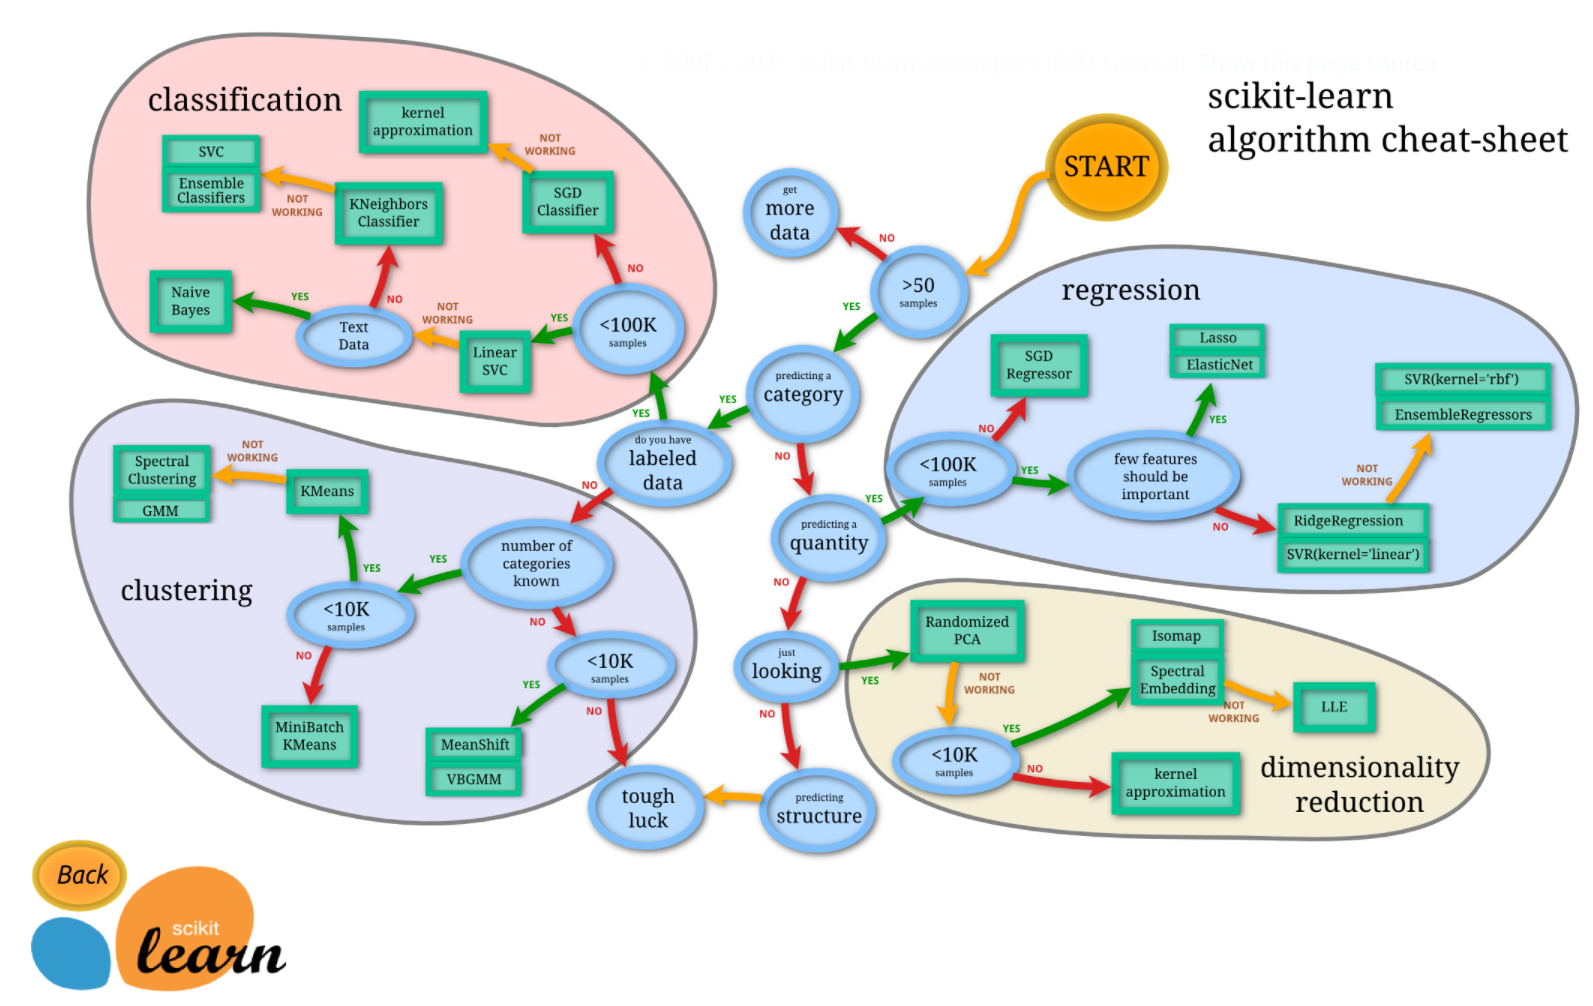

In [ ]:
from IPython.display import Image
Image('sklearn_method_selection.png')

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

- **Random Forest**

In [ ]:
## Import RF classifier
from sklearn.ensemble import RandomForestClassifier

In [ ]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=4124)

In [ ]:
#kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=4124)
num_of_trees = [10, 50, 100] #, 250, 500, 1000, 1500

cv_accs = np.zeros((5,len(num_of_trees)))
cv_aucs = np.zeros((5,len(num_of_trees)))

i = 0
for train_index, test_index in kfold.split(X_train, y_train):
    X_train_train = X_train.iloc[train_index]
    y_train_train = y_train.iloc[train_index]
    X_holdout = X_train.iloc[test_index]
    y_holdout = y_train.iloc[test_index]
    
    j = 0
    for num_trees in num_of_trees:
        acc_forest = RandomForestClassifier(max_depth=4,
                                            n_estimators=num_trees, 
                                            max_samples=200, 
                                            random_state=1341)
        auc_forest = RandomForestClassifier(max_depth=3,
                                            n_estimators=num_trees, 
                                            max_samples=200, 
                                            random_state=1341)
        
        acc_forest.fit(X_train_train, y_train_train)
        auc_forest.fit(X_train_train, y_train_train)

        cv_accs[i,j] = accuracy_score(y_holdout, acc_forest.predict(X_holdout))
        cv_aucs[i,j] = roc_auc_score(y_holdout, auc_forest.predict_proba(X_holdout)[:,1])
        j = j + 1
    i = i + 1

  #Time 3m:16s


In [ ]:
## Accuracy
100*np.mean(cv_accs, axis=0)

array([91.15512045, 91.58779926, 91.19218314])

In [ ]:
## Roc Auc
np.mean(cv_aucs, axis=0) 

array([0.90189236, 0.91893   , 0.92081228])

In [ ]:
##Make validation dataset for KNeighbors Classifier and Linear SVM
X_train_train, X_val, y_train_train, y_val = train_test_split(X_train, y_train,
                                                                 test_size=.2,
                                                                   shuffle=True,
                                                                   random_state=41,
                                                                   stratify=y_train)



*   **KNeighbors Classifier**



In [ ]:
## import KNeighborClassifier
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
## make the model
knn = KNeighborsClassifier(5, n_jobs=-1, algorithm='ball_tree')

In [ ]:
## fit model
knn.fit(X_train_train[['drug_A',	'drug_B',	'drug_C',	'bin_417380',	'bin_417614',	'bin_417740',	'bin_999001']], y_train_train)

##Time: ~19 min

KNeighborsClassifier(algorithm='ball_tree', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
                     weights='uniform')

In [ ]:
## Roc Auc
roc_auc_score(y_val, knn.predict(X_val[['drug_A',	'drug_B',	'drug_C',	'bin_417380',	'bin_417614',	'bin_417740',	'bin_999001']]))

##Time: 11m 46s

0.9237004226998831

In [ ]:
## Accuracy
preds_knn_val = knn.predict(X_val[['drug_A','drug_B',	'drug_C',	'bin_417380',	'bin_417614',	'bin_417740',	'bin_999001']])

##time 12m 4s


In [ ]:
np.round(100*accuracy_score(y_val, preds_knn_val),2)

93.65

- **Linear Support Vector Machines**

In [ ]:
## import LinearSVC
from sklearn.svm import LinearSVC

In [ ]:
## make model
svc_linear = LinearSVC(kernel='linear')

## fit model
svc_linear.fit(X_train_train, y_train_train)

In [ ]:
preds_Lsvc_val = svc_linear.predict(X_val)

In [ ]:
## Roc Auc
roc_auc_score(y_val, preds_Lsvc_val)*100

In [ ]:
## Accuracy
np.round(100*accuracy_score(y_val, preds_Lsvc_val),2))
